In [19]:
# for this notebook make the path in the same folder (currently is in the project folder)
import os
import sys
import importlib

# Add the path to the val03 folder to sys.path so modules in the same folder can be imported
sys.path.append(os.path.join('notebooks', '103 different weighted'))

from scripts import style
importlib.reload(style)
style.set_style()

In [20]:
# STEP 0. Set up: import and reload py103, pull key functions

import importlib
import py103

# Always reload so edits to py103.py are picked up
importlib.reload(py103)

from py103 import (
    # Core data / transforms
    download_price_series,
    make_transformed_time_regression_data,
    TRANSFORM_FUNCS,

    # Core experiments
    run_transform_experiment,
    run_all_transforms_experiment,
    run_logprice_experiment,

    # Weighted training comparison
    run_weighted_training_comparison_single_transform,
    plot_weighted_training_comparison,

    # Normality-regularized selection
    run_normality_regularized_model_single_transform,

    # Residual diagnostics
    compute_validation_residuals_transform_and_price,
    compute_normality_stats,
    plot_validation_residual_diagnostics,

    # Plotting helpers
    plot_transform_trend,
    plot_destransformed_price_trend,
    subplot_all_transforms_and_destransforms,
)


In [21]:
# STEP 1. Basic: download NVDA and build (X, y, dates) for one transform

# 1A) Download NVDA close prices
df_nvda = download_price_series(
    ticker="^GSPC",
    start="2015-01-01",
    end=None,          # up to latest available
)
print(df_nvda.head())
print(df_nvda.tail())
print(df_nvda.columns)

# 1B) Choose one transform (e.g. 'log_close') and build regression data
X_log, y_log, dates_log = make_transformed_time_regression_data(
    df=df_nvda,
    transform_name="log_close",   # any key in TRANSFORM_FUNCS
    price_col="close",
)

print("X_log shape:", X_log.shape)      # (n, 1)
print("y_log shape:", y_log.shape)      # (n,)
print("dates_log length:", len(dates_log))

# 1C) Inspect available transforms
print("Available transforms:", list(TRANSFORM_FUNCS.keys()))


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Price             close
Ticker            ^GSPC
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893
Price             close
Ticker            ^GSPC
Date                   
2025-11-21  6602.990234
2025-11-24  6705.120117
2025-11-25  6765.879883
2025-11-26  6812.609863
2025-11-28  6849.089844
MultiIndex([('close', '^GSPC')],
           names=['Price', 'Ticker'])
X_log shape: (2744, 1)
y_log shape: (2744,)
dates_log length: 2744
Available transforms: ['close', 'log_close', 'sqrt_close', 'diff_close', 'simple_return', 'log_return', 'zscore_log_close']


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== ^GSPC Elastic Net trend on transform 'log_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 1.266418e-01

--- Metrics in TRANSFORM space (y_t) and PRICE space (Close) ---
[train    ]  y: RMSE=0.087016, lin=0.102001, exp=0.109417   |  price: RMSE=273.136818, lin=349.261488, exp=379.017573
[val      ]  y: RMSE=0.169368, lin=0.121415, exp=0.127460   |  price: RMSE=675.347071, lin=489.824995, exp=514.306408
[test     ]  y: RMSE=0.263806, lin=0.296048, exp=0.297859   |  price: RMSE=1362.216213, lin=1567.692795, exp=1588.301845
[train_val]  y: RMSE=0.113337, lin=0.132376, exp=0.132568   |  price: RMSE=412.176259, lin=504.489681, exp=506.626324

[log_close] variance: 0.12664181020278464

=== Transform-space RMSE metrics (y_t) for log_close ===
train     | RMSE=0.087016, lin=0.102001, exp=0.109417
val       | RMSE=0.169368, lin=0.121415, exp=0.127460
test      | RMSE=0.263806, lin=0.296048, exp=0.297859
train_val | RMSE=0.113337, lin=0.132376, exp=0.132568


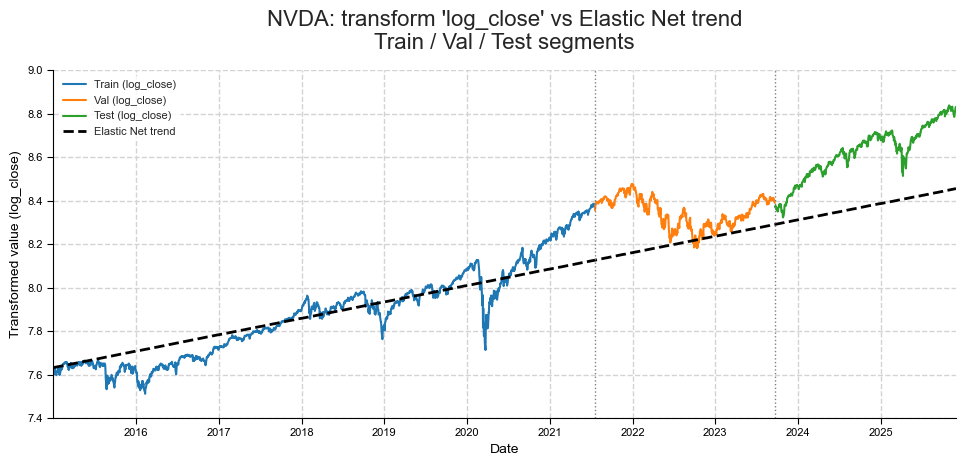

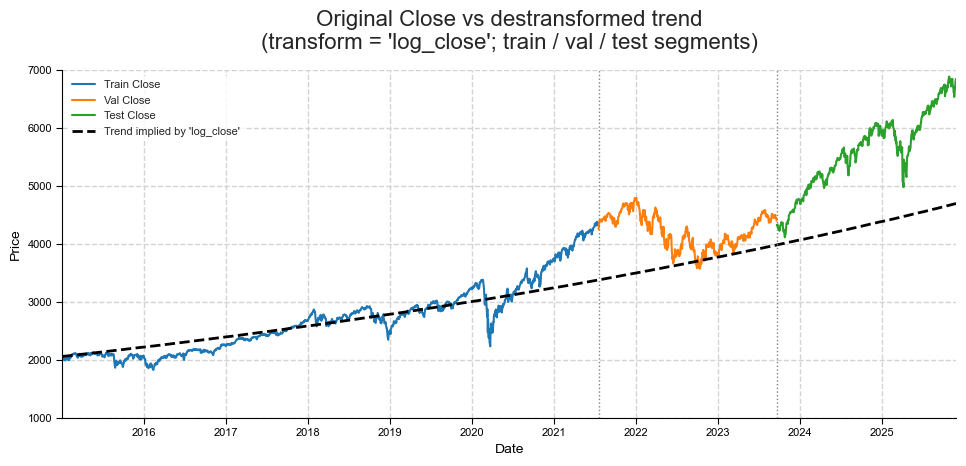

In [22]:
# STEP 2. Single-transform Elastic Net experiment + plots (transform & price space)

# 2A) Run full pipeline for ONE transform (e.g. 'log_close')
log_result, log_model, df_nvda = run_transform_experiment(
    transform_name="log_close",
    ticker="^GSPC",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=1,         # 1 = linear in time; can try 2,3,...
)

# log_result["variance"] = variance of transformed series
print("\n[log_close] variance:", log_result["variance"])

# log_result["metrics"] is a dict with keys: 'train', 'val', 'test', 'train_val'
# Each entry has: rmse, rmse_w_linear, rmse_w_exp (all in TRANSFORM space)
print("\n=== Transform-space RMSE metrics (y_t) for log_close ===")
for split_name, m in log_result["metrics"].items():
    print(
        f"{split_name:9s} | "
        f"RMSE={m['rmse']:.6f}, "
        f"lin={m['rmse_w_linear']:.6f}, "
        f"exp={m['rmse_w_exp']:.6f}"
    )

# 2B) Plot in TRANSFORM space with colored train/val/test
plot_transform_trend(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)

# 2C) Plot in PRICE space (detransformed trend vs Close)
plot_destransformed_price_trend(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== ^GSPC transform 'close' (degree=3) ===
Variance: 1.689642e+06
--- TRAIN / VAL / TEST metrics (transform vs price) ---
[train    ]  y: RMSE=173.381925, lin=206.570850, exp=211.179666   |  price: RMSE=173.381925, lin=206.570850, exp=211.179666
[val      ]  y: RMSE=857.912800, lin=1016.557596, exp=1024.148462   |  price: RMSE=857.912800, lin=1016.557596, exp=1024.148462
[test     ]  y: RMSE=1357.899325, lin=1426.462613, exp=1439.476213   |  price: RMSE=1357.899325, lin=1426.462613, exp=1439.476213

=== ^GSPC transform 'log_close' (degree=3) ===
Variance: 1.266418e-01
--- TRAIN / VAL / TEST metrics (transform vs price) ---
[train    ]  y: RMSE=0.080021, lin=0.086693, exp=0.091657   |  price: RMSE=237.994381, lin=289.848898, exp=311.105063
[val      ]  y: RMSE=0.137252, lin=0.121953, exp=0.124931   |  price: RMSE=578.268889, lin=526.704045, exp=540.845589
[test     ]  y: RMSE=0.137189, lin=0.147461, exp=0.150332   |  price: RMSE=843.525091, lin=965.760049, exp=986.938599

=== ^GSPC tra

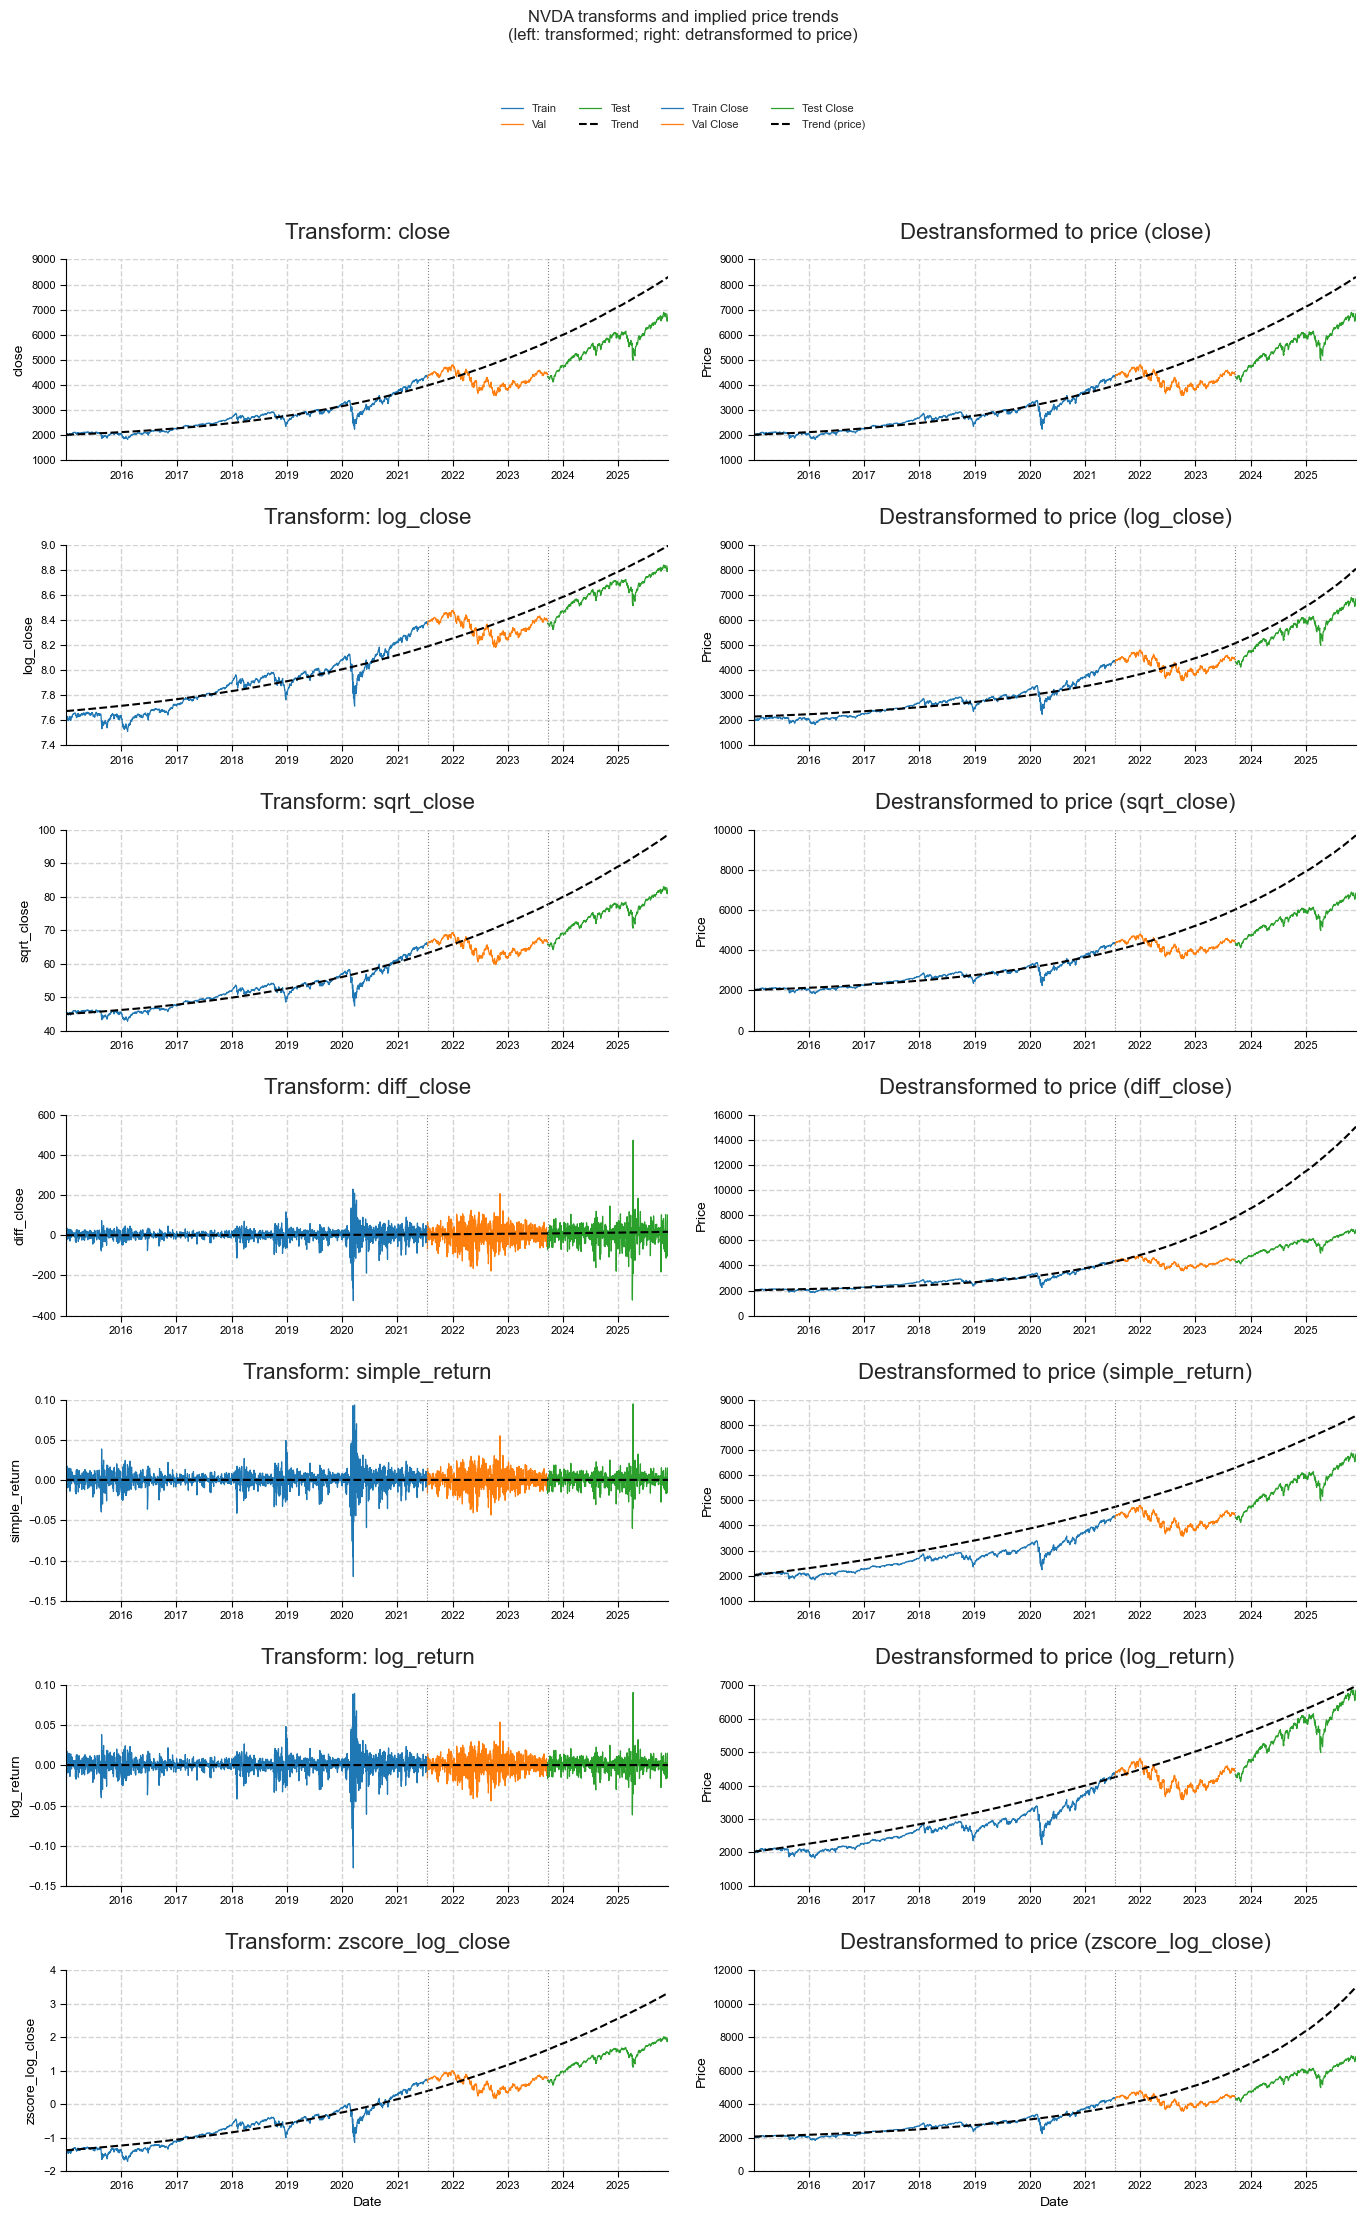

In [35]:
# STEP 3. Multi-transform experiment: compare all transforms numerically

# 3A) Run the experiment over ALL transforms in TRANSFORM_FUNCS
all_results, all_models, df_all = run_all_transforms_experiment(
    transform_names=None,      # None => use all transforms in TRANSFORM_FUNCS
    ticker="^GSPC",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=3,
)

# all_results[transform_name] has:
#   - 'variance'
#   - 'metrics' (rmse, rmse_w_linear, rmse_w_exp for train/val/test/train_val)
print("\n=== SUMMARY: test RMSE in TRANSFORM space for each transform ===")
for name, res in all_results.items():
    m_test = res["metrics"]["test"]
    print(
        f"{name:16s} | "
        f"RMSE={m_test['rmse']:.6f}, "
        f"lin={m_test['rmse_w_linear']:.6f}, "
        f"exp={m_test['rmse_w_exp']:.6f}"
    )

# 3B) Global visualization: each transform in a row, with transform & price panels
subplot_all_transforms_and_destransforms(
    df=df_all,
    models=all_models,
    transform_names=None,   # None => all transforms
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== Weighted-training comparison for transform 'log_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50, ratio_last_first=10.0
[mode=plain ]  VAL y: RMSE=0.169368, lin=0.121415, exp=0.127460   |  VAL price: RMSE=675.347071, lin=489.824995, exp=514.306408
[mode=linear]  VAL y: RMSE=0.151351, lin=0.105387, exp=0.111173   |  VAL price: RMSE=610.538704, lin=429.964927, exp=453.446292
[mode=exp   ]  VAL y: RMSE=0.134465, lin=0.088013, exp=0.093290   |  VAL price: RMSE=547.641908, lin=362.150059, exp=383.450396

=== Weighted-training comparison in TRANSFORM and PRICE space ===
Mode=plain  | y_val: RMSE=0.169368, lin=0.121415, exp=0.127460   ||   price_val: RMSE=675.347071, lin=489.824995, exp=514.306408
Mode=linear | y_val: RMSE=0.151351, lin=0.105387, exp=0.111173   ||   price_val: RMSE=610.538704, lin=429.964927, exp=453.446292
Mode=exp    | y_val: RMSE=0.134465, lin=0.088013, exp=0.093290   ||   price_val: RMSE=547.641908, lin=362.150059, exp=383.450396


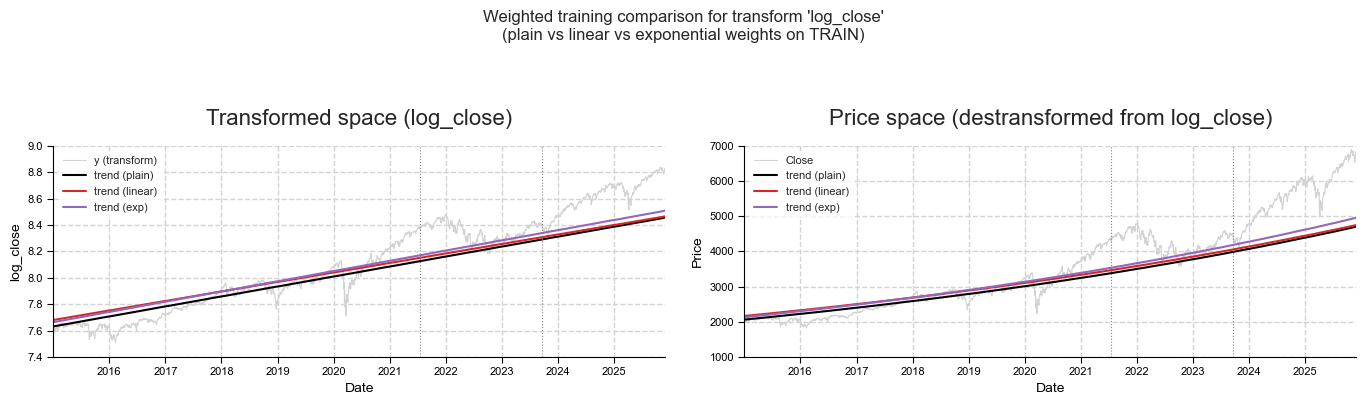

In [24]:
# STEP 4 (FIXED). Weighted training vs plain training (plain / linear / exp)

import importlib
import py103

importlib.reload(py103)

from py103 import (
    run_weighted_training_comparison_single_transform,
    plot_weighted_training_comparison,
    compute_price_space_metrics_for_model,
)

# 4A) Run weighted-training comparison for ONE transform (e.g. 'log_close')
wt_results, wt_models, df_wt = run_weighted_training_comparison_single_transform(
    transform_name="log_close",
    ticker="^GSPC",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    ratio_last_first=10.0,   # exp weights: last / first weight ratio
    poly_degree=1,
)

print("\n=== Weighted-training comparison in TRANSFORM and PRICE space ===")
for mode, metrics_y in wt_results.items():
    # metrics_y is a dict by split: 'train', 'val', 'test', 'train_val'
    m_y_val = metrics_y["val"]

    # Compute PRICE-space metrics for this mode/model
    price_metrics = compute_price_space_metrics_for_model(
        df=df_wt,
        model=wt_models[mode],
        transform_name="log_close",
        train_frac=0.6,
        val_frac=0.2,
        ratio_last_first=10.0,
    )
    m_p_val = price_metrics["val"]

    print(
        f"Mode={mode:6s} | "
        f"y_val: RMSE={m_y_val['rmse']:.6f}, "
        f"lin={m_y_val['rmse_w_linear']:.6f}, "
        f"exp={m_y_val['rmse_w_exp']:.6f}   ||   "
        f"price_val: RMSE={m_p_val['rmse']:.6f}, "
        f"lin={m_p_val['rmse_w_linear']:.6f}, "
        f"exp={m_p_val['rmse_w_exp']:.6f}"
    )

# 4B) Plot the three training schemes together (transform + price panels)
plot_weighted_training_comparison(
    df=df_wt,
    models_by_mode=wt_models,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)


Validation residuals (transform space) length: 548
Validation residuals (price space) length: 548

=== Normality stats (price-space validation residuals) ===
n            : 548
mean         : 554.898704
std          : 385.294682
skew         : 0.332737
kurt_excess  : -1.206125
jb_stat      : 43.270397
jb_pvalue    : 0.000000

=== Validation residual diagnostics (price, transform='log_close') ===
n = 548
mean(resid) = 5.548987e+02
std(resid)  = 3.852947e+02
t-stat (H0: mean=0) = 33.7141,  p-value = 0.0000
skewness = 0.3327,  excess kurtosis = -1.2061


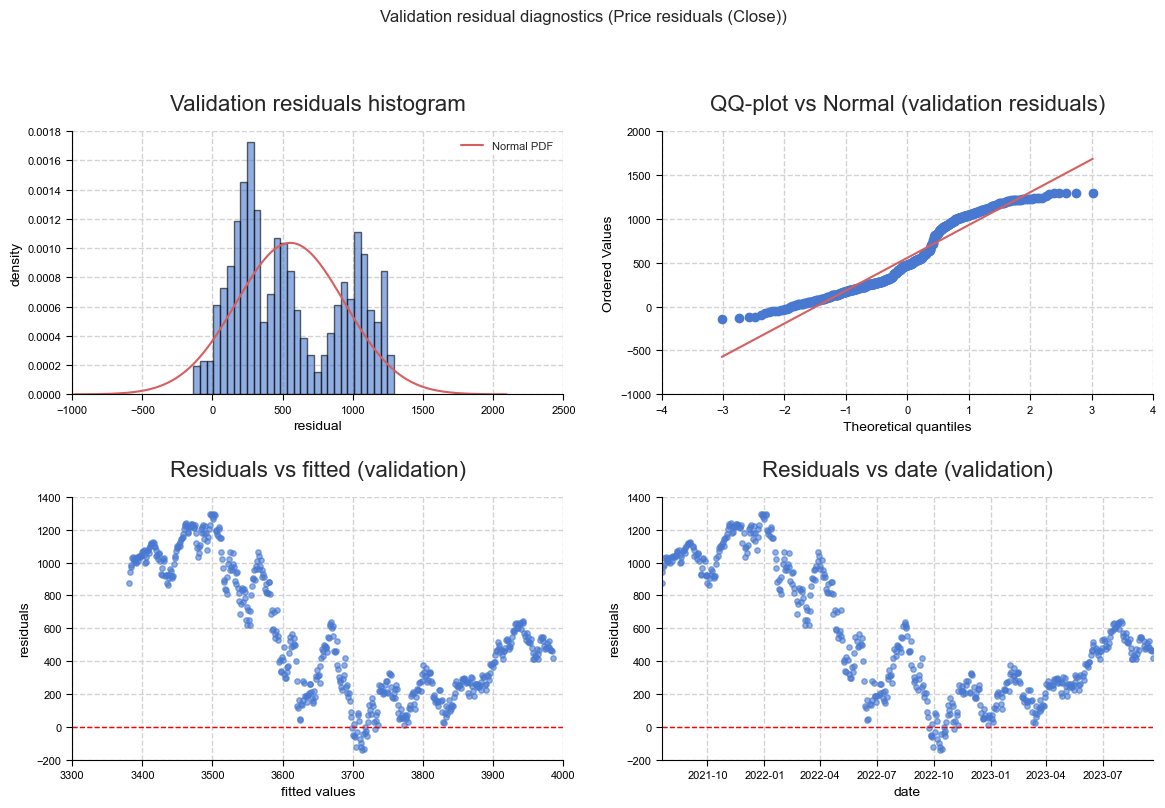

In [25]:
# STEP 5. Residual diagnostics on the VALIDATION set (normality etc.)

# Here we reuse the log_model from STEP 2.
# You can also plug in any model from all_models or wt_models.

# 5A) Get validation residuals in transform & price space
res_val = compute_validation_residuals_transform_and_price(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)

resid_y_val = res_val["resid_y_val"]
resid_p_val = res_val["resid_p_val"]

print("Validation residuals (transform space) length:", resid_y_val.shape[0])
print("Validation residuals (price space) length:", resid_p_val.shape[0])

# 5B) Compute normality diagnostics (Jarque-Bera etc.) for price residuals
stats_price = compute_normality_stats(resid_p_val)
print("\n=== Normality stats (price-space validation residuals) ===")
for k, v in stats_price.items():
    print(f"{k:12s} : {v:.6f}" if isinstance(v, float) else f"{k:12s} : {v}")

# 5C) Full residual diagnostic plots (hist, QQ, residuals vs fitted/date)
#     space='transform' or 'price'
plot_validation_residual_diagnostics(
    df=df_nvda,
    model=log_model,
    transform_name="log_close",
    space="price",       # or "transform"
    train_frac=0.6,
    val_frac=0.2,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== Normality-regularized model selection for transform 'log_close' (normality_space=price) ===
Grids: alpha=[0.01, 0.1, 1.0], l1_ratio=[0.1, 0.5, 0.9], degree=[1, 2, 3], weights=['plain', 'linear', 'exp']
Objective: obj = 1.0 * RMSE_val_price + 1.0 * JB_stat

alpha=0.01, l1=0.10, deg=1, wmode=plain       | VAL price RMSE=462.892100 | JB=58.386, p=0.000 | obj=521.278086
alpha=0.01, l1=0.10, deg=1, wmode=linear      | VAL price RMSE=498.665715 | JB=62.109, p=0.000 | obj=560.774875
alpha=0.01, l1=0.10, deg=1, wmode=exp         | VAL price RMSE=501.386815 | JB=62.091, p=0.000 | obj=563.478217
alpha=0.01, l1=0.10, deg=2, wmode=plain       | VAL price RMSE=883.742133 | JB=65.659, p=0.000 | obj=949.400810
alpha=0.01, l1=0.10, deg=2, wmode=linear      | VAL price RMSE=1016.342805 | JB=63.658, p=0.000 | obj=1080.000611
alpha=0.01, l1=0.10, deg=2, wmode=exp         | VAL price RMSE=1118.670488 | JB=62.107, p=0.000 | obj=1180.777436
alpha=0.01, l1=0.10, deg=3, wmode=plain       | VAL price RMSE

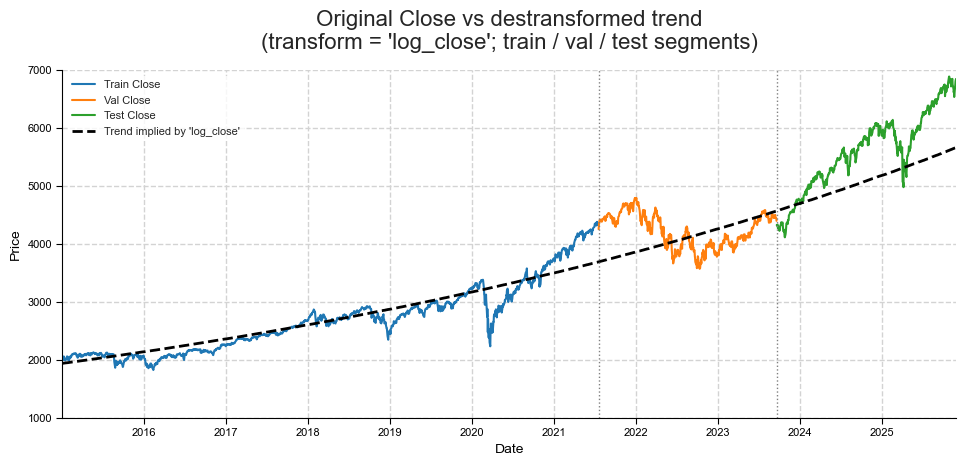


=== Validation residual diagnostics (price, transform='log_close') ===
n = 548
mean(resid) = 1.129069e+02
std(resid)  = 4.442045e+02
t-stat (H0: mean=0) = 5.9501,  p-value = 0.0000
skewness = 0.4399,  excess kurtosis = -1.2981


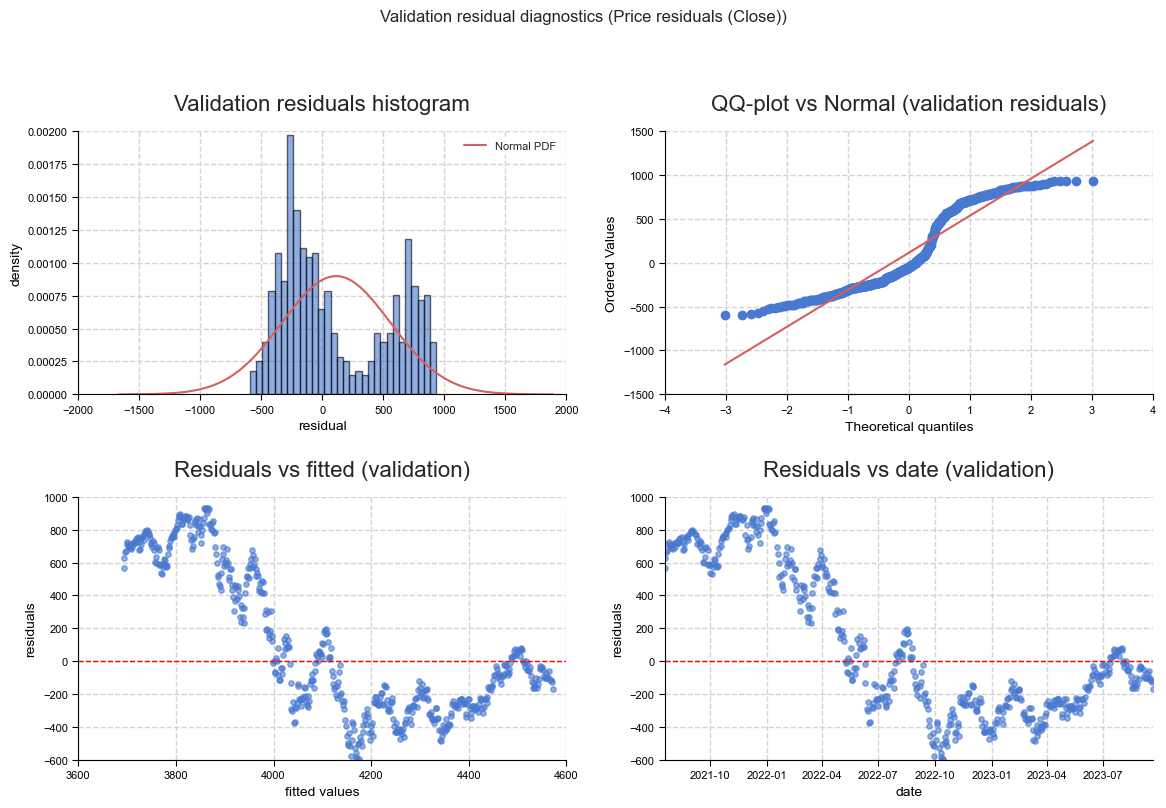

In [26]:
# STEP 6. Normality-regularized model selection
#         (jointly optimizing RMSE + residual normality)

best_summary, best_model, all_candidates, df_norm = (
    run_normality_regularized_model_single_transform(
        transform_name="log_close",
        ticker="^GSPC",
        start="2015-01-01",
        end=None,
        alpha_grid=(0.01, 0.1, 1.0),
        l1_ratio_grid=(0.1, 0.5, 0.9),
        poly_degree_grid=(1, 2, 3),
        train_weight_modes=("plain", "linear", "exp"),
        train_frac=0.6,
        val_frac=0.2,
        random_state=0,
        ratio_last_first=10.0,
        w_rmse=1.0,        # weight on validation RMSE in price space
        w_jb=1.0,          # weight on Jarque-Bera statistic
        normality_space="price",  # or "transform"
    )
)

print("\n=== BEST CONFIG (RMSE + normality) ===")
for k, v in best_summary.items():
    print(f"{k:18s} : {v}")

# Optionally, inspect some candidate configs:
print("\nNumber of candidate models:", len(all_candidates))
some_key = next(iter(all_candidates.keys()))
print("\nExample candidate:", some_key)
for k, v in all_candidates[some_key].items():
    print(f"  {k:18s} : {v}")

# Plot diagnostics for the best_model in price space
plot_destransformed_price_trend(
    df=df_norm,
    model=best_model,
    transform_name="log_close",
    train_frac=0.6,
    val_frac=0.2,
)

plot_validation_residual_diagnostics(
    df=df_norm,
    model=best_model,
    transform_name="log_close",
    space="price",
    train_frac=0.6,
    val_frac=0.2,
)


In [27]:
import importlib
import py103

importlib.reload(py103)

from py103 import (
    run_transform_experiment,
    plot_validation_residual_diagnostics,
    print_normality_tests_all_splits,
)

# Fit your model on NVDA with, say, log_close
log_result, log_model, df_nvda = run_transform_experiment(
    transform_name="log_close",
    ticker="^GSPC",
    start="2015-01-01",
    end=None,
    alpha=0.1,
    l1_ratio=0.5,
    random_state=0,
    train_frac=0.6,
    val_frac=0.2,
    poly_degree=1,
)


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)



=== ^GSPC Elastic Net trend on transform 'log_close' (degree=1) ===
Alpha=0.1000, l1_ratio=0.50
Variance of transformed series: 1.266418e-01

--- Metrics in TRANSFORM space (y_t) and PRICE space (Close) ---
[train    ]  y: RMSE=0.087016, lin=0.102001, exp=0.109417   |  price: RMSE=273.136818, lin=349.261488, exp=379.017573
[val      ]  y: RMSE=0.169368, lin=0.121415, exp=0.127460   |  price: RMSE=675.347071, lin=489.824995, exp=514.306408
[test     ]  y: RMSE=0.263806, lin=0.296048, exp=0.297859   |  price: RMSE=1362.216213, lin=1567.692795, exp=1588.301845
[train_val]  y: RMSE=0.113337, lin=0.132376, exp=0.132568   |  price: RMSE=412.176259, lin=504.489681, exp=506.626324


c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:1088: RuntimeWarning: overflow encountered in scalar multiply
  t_stat = mean_res / (std_res / np.sqrt(n)) if std_res > 0 else np.nan
c:\Users\herie\GitHub\Proyectos\En Pausa\Estimacion de Tendencia\notebooks\103 different weighted\py103.py:504: RuntimeWarning: overflow encountered in scalar multiply
  price_hat_all[t] = price_hat_all[t - 1] * (1.0 + y_hat_all[t])



=== Normality tests for residuals in transform-space (transform='simple_return') ===
[train    ] n=1645, mean=-7.878e+00, std=1.428e-01, t=-2238.378, p_t=0.000, JB=95.898, p_JB=0.000, skew=-0.008, kurt_excess=-1.183
[val      ] n= 548, mean=-8.208e+00, std=4.881e-02, t=-3936.255, p_t=0.000, JB=32.610, p_JB=0.000, skew=0.034, kurt_excess=-1.193
[test     ] n= 550, mean=-8.372e+00, std=4.879e-02, t=-4024.116, p_t=0.000, JB=30.868, p_JB=0.000, skew=-0.017, kurt_excess=-1.160
[train_val] n=2193, mean=-7.961e+00, std=1.904e-01, t=-1958.221, p_t=0.000, JB=130.613, p_JB=0.000, skew=-0.006, kurt_excess=-1.196

VAL t-test p-value for mean=0: 0.0
The residuals are NOT normally distributed (reject H0 at 5% level)
VAL Jarque–Bera p-value        : 8.293336758723419e-08
The train+val residuals are NOT normally distributed (reject H0 at 5% level)

=== Validation residual diagnostics (transform, transform='simple_return') ===
n = 548
mean(resid) = -8.207728e+00
std(resid)  = 4.881238e-02
t-stat (H0: 

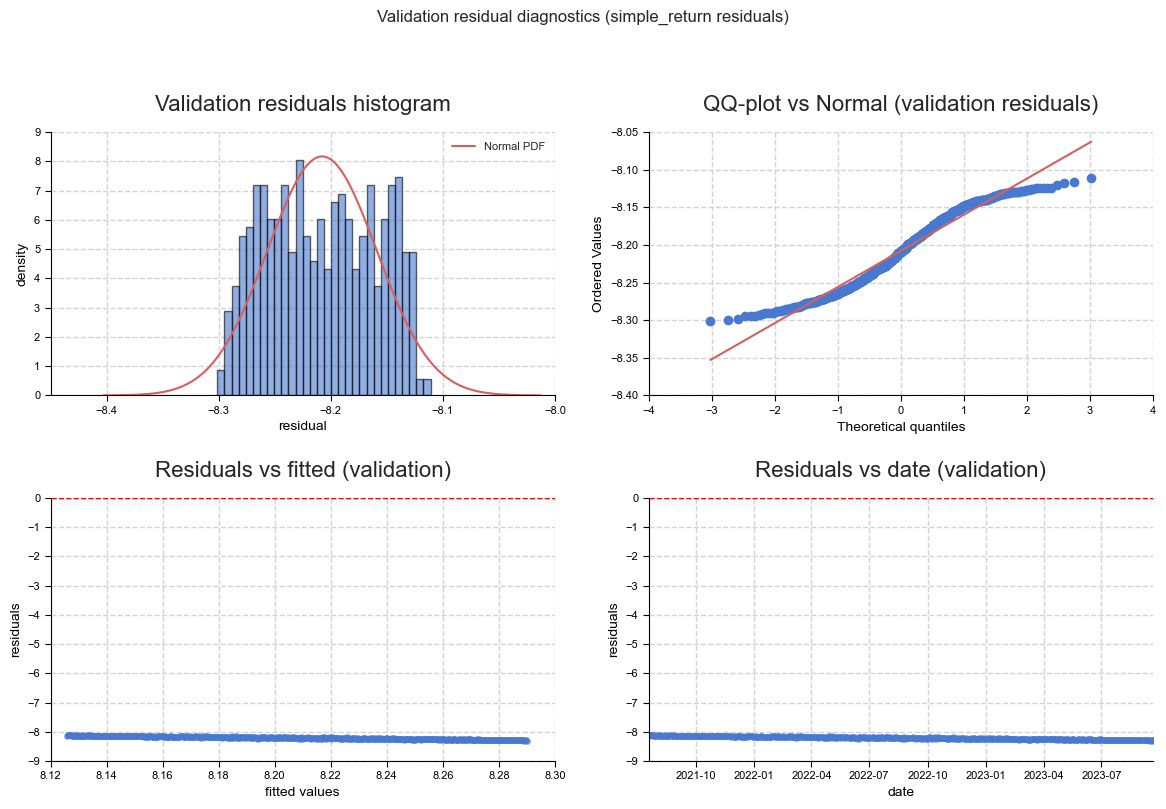

In [33]:
stats_all = print_normality_tests_all_splits(
    df=df_nvda,
    model=log_model,
    transform_name="simple_return",
    space="transform",   # residuals in transformed data (important!)
    train_frac=0.6,
    val_frac=0.2,
)

# Example: access numbers programmatically
stats_train = stats_all["train"]
stats_val = stats_all["val"]
stats_train_val = stats_all["train_val"]

print("\nVAL t-test p-value for mean=0:", stats_val["t_pvalue_mean0"])
if stats_val["jb_pvalue"] < 0.05:
    print("The residuals are NOT normally distributed (reject H0 at 5% level)")
print("VAL Jarque–Bera p-value        :", stats_val["jb_pvalue"])
if stats_train_val["jb_pvalue"] < 0.05:
    print("The train+val residuals are NOT normally distributed (reject H0 at 5% level)")
plot_validation_residual_diagnostics(
    df=df_nvda,
    model=log_model,
    transform_name="simple_return",
    space="transform",   # residuals in transformed data
)